## 参照
https://www.sambaiz.net/article/212/

In [1]:
cd drive/MyDrive/GDP_pytorch/

/content/drive/MyDrive/GDP_pytorch


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

%matplotlib inline

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

In [117]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride=1, padding=1)
        # mu, var
        self.fc1 = nn.Linear(3136, 2)
        self.fc2 = nn.Linear(3136, 2)        
        #Decoder Layers
        self.fc3 = nn.Linear(2, 3136)
        self.t_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2)
        self.leaky_relu = F.leaky_relu
        self.pool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()
      
    def encode(self, x):
        # encode
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.leaky_relu(self.conv4(x))
        x = x.view(self.batch_size, -1)
        return self.fc1(x), self.fc2(x)
      
    def decode(self, x):
        x  =self.fc3(x)
        x = x.view(self.batch_size, 64, 7, 7)        
        x = self.leaky_relu(self.t_conv1(x))
        x = self.leaky_relu(self.t_conv2(x))
        x = self.leaky_relu(self.t_conv3(x))
        x = self.leaky_relu(self.t_conv4(x))
        x = self.sigmoid(x)
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std        

    def forward(self, x):
        self.batch_size = x.shape[0]         
        mu, logvar = self.encode(x)  
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    

In [118]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [119]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE().to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

In [120]:
for epoch in range(5):
  running_loss = 0.0
  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()    
    outputs, mu, logvar = model(images)
    loss = loss_function(outputs, images, mu, logvar)
    loss.backward()
    optimizer.step()   
    
    # print statistics
    running_loss += loss.item()
    if i % 800 == 799:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 800))
      running_loss = 0.0

print('Finished Training')   

[1,   800] loss: 0.230
[2,   800] loss: 0.091
[3,   800] loss: 0.070
[4,   800] loss: 0.069
[5,   800] loss: 0.068
Finished Training


In [121]:
images, labels = iter(testloader).__next__()
images = images.to(device)
outputs, mu, logvar = model(images)
# outputs = outputs.to('cpu').detach().numpy().copy()

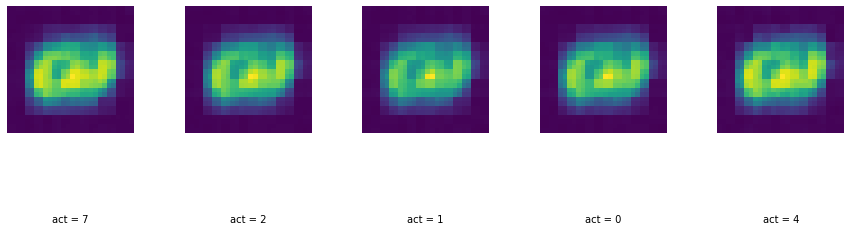

In [122]:
n_to_show = 5

fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for idx in range(5):
    img = outputs[idx]
    img = img.squeeze().permute(1,0).to('cpu').detach().numpy()
    ax = fig.add_subplot(1, n_to_show, idx+1)
    ax.axis('off')
    ax.text(0.5, -0.7, 'act = ' + str(labels[idx].to('cpu').detach().numpy()), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)